# Minimum Sliced-Wasserstein Estimators for Multivariate Elliptically Contoured Stable distributions

In this notebook, we consider the task of estimating the parameters of a multivariate elliptically contoured stable distribution using the minimum expected Sliced-Wasserstein estimator (MESWE). The goal is to empirically validate the consistency of MESWE (Theorem 3, [1]) and the convergence of MESWE to MSWE (Theorem 4, [1]).

The target is a 10-dimensional elliptically contoured stable distribution $\mathcal{E}\alpha\mathcal{S}_c(\mathbf{I}, \mathbf{m}_\star)$, with $\alpha = 1.8$ and $\mathbf{m}_\star \in \mathbb{R}^{10}$. In this experiment, each component of $\mathbf{m}_\star$ is 2. 
We generate $n$ i.i.d. observations from the target distribution and denote its empirical distribution by $\hat{\mu}_n$. The objective of MESWE is:

\begin{align}
   \hat{\mathbf{m}}_{n,m} = \text{argmin}_{\mathbf{m}}\ \mathbb{E} \big[ \textbf{SW}_2 \big(\hat{\mu}_n, \hat{\mu}_{\mathbf{m}, m} \big) \big]
\end{align}

where $\hat{\mu}_{\mathbf{m}, m}$ denotes the empirical distribution obtained by drawing $m$ i.i.d. samples from $\mathcal{E}\alpha\mathcal{S}_c(\mathbf{I}, \mathbf{m})$, $\mathbf{m} \in \mathbb{R}^{10}$. The expectation is taken with respect to the different sets of $m$ samples that we generate.


#### Requirements
- Numpy
- Scipy
- Matplotlib
- IPython Parallel (for parallel computing)

#### Reference
[1] Kimia Nadjahi, Alain Durmus, Umut Şimşekli, Roland Badeau. *Asymptotic Guarantees for Learning Generative Models with the Sliced-Wasserstein Distance.* arXiv, 2019.

In [1]:
import numpy as np
import os
from tqdm import tqdm
from ipyparallel import Client
from time import time
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# Create the repository that will contain the figures
directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
# Configuration of IPython Parallel
rc = Client()
dv = rc[:]

In [4]:
# Parameters of the target multivariate elliptically contoured stable distribution
dim = 10
alpha_star = 1.8
m_star = 2 * np.ones(dim)

### Illustration of the consistency of MESWE

For different values of $n$, we draw $n$ samples from the target distribution and we compute the (approximate) MESWE of order 2, using one generated dataset of size $m = n$. We repeat this experiment several times and we report for each $n$ the average mean squared error between the estimate $\hat{\mathbf{m}}_{n,n}$ and the data-generating parameters $\mathbf{m}_\star$, and its standard deviation. 

In [5]:
# This function generates 'n_samples' observations from the target and returns the MESWE of order 2, 
# where the expected SW distance is computed between the 'n_samples' observations and 
# 'n_montecarlo' generated datasets of size m = 'n_samples'.
def compute_meswe_m_equal_n(n_samples):
    # Imports
    import numpy as np
    import random
    seed = random.randrange(1000)
    np.random.seed(seed)
    import sys
    sys.path.append('code/')
    import estimators
    
    # Parameters of the target multivariate elliptically contoured stable distribution
    dim = 10
    alpha_star = 1.8
    
    # Hyperparameters for the MESWE computation
    n_projections = 1  # number of directions of projections for the SW
    n_montecarlo = 1  # number of generated datasets
    
    # Sample the target
    m_star = 2 * np.ones(dim)
    Gamma_star = np.eye(dim)
    scale = 2. * np.cos(np.pi * alpha_star / 4.) ** (2. / alpha_star)
    assert ((alpha_star / 2.) != 1)
    A = scale * estimators.generate_std_1d_alphastable(alpha=alpha_star / 2., 
                                                        beta=1., size=(n_samples, 1))
    G = np.random.normal(size=(n_samples, dim))
    G = np.matmul(G, Gamma_star.T)
    X = np.sqrt(A) * G + m_star
    
    # Compute the MESWE of order 2 and return the parameters found
    meswe_mean = estimators.compute_meswe(X, n_montecarlo, n_samples, n_projections, 
                                          batch_size=n_samples, distribution="ellipstable", 
                                          order=2, n_iterations=20000)
    return meswe_mean

In [6]:
# Initialization
range_nm = [10, 50, 100, 500, 1000, 5000, 10000]  # different values of n (= m)
len_range_nm = len(range_nm)
n_exp = 100  # number of repetitions of the MESWE computation for each n (= m)

meswe_mean = np.zeros((len_range_nm, n_exp, dim))

# For each n (= m), we compute 'n_exp' times (in parallel) the MESWE of order 2
for k in range(len_range_nm):
    print("Starting experiment for n=m=" + str(range_nm[k]) + " samples...")
    params_list = [range_nm[k]] * n_exp
    start = time()
    res = dv.map_sync(compute_meswe_m_equal_n, iter(params_list))
    stop = time()
    # Store the estimate
    meswe_mean[k] = np.array(res)
    print("Done in " + str((stop - start) / 60.0) + " min. \n")

# Compute the mean squared errors
mse_mean = ((meswe_mean - m_star)**2).mean(axis=2)

Starting experiment for n=m=10 samples...
Done in 1.9632022579511006 min. 

Starting experiment for n=m=50 samples...
Done in 2.124730674425761 min. 

Starting experiment for n=m=100 samples...
Done in 2.2819728295008344 min. 

Starting experiment for n=m=500 samples...
Done in 3.097671548525492 min. 

Starting experiment for n=m=1000 samples...
Done in 4.481852853298188 min. 

Starting experiment for n=m=5000 samples...
Done in 12.876296818256378 min. 

Starting experiment for n=m=10000 samples...
Done in 26.27291166782379 min. 



/usr/lib64/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib64/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


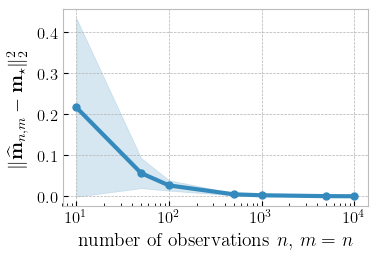

In [7]:
# Plot the average mean squared error and its standard deviation against n
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('bmh')
fontsize = 12
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': True,
      'errorbar.capsize': 4}
plt.rcParams.update(params)
plt.rc('font', family='Times')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [4, 5]
lw = 3
ms = 5

plt.figure(0)

# Plot for the mean
plt.subplot(2, 1, 1)
plot_mu, = plt.semilogx(range_nm, mse_mean.mean(axis=1), 'o-', lw=lw, ms=ms)
color = plot_mu.get_color()
plt.fill_between(range_nm, mse_mean.mean(axis=1) - mse_mean.std(axis=1), 
                 mse_mean.mean(axis=1) + mse_mean.std(axis=1), alpha=0.2, color=color)
plt.xlabel('number of observations $n$, $m = n$')
plt.ylabel('$\| \widehat{\mathbf{m}}_{n,m} - \mathbf{m}_\star \|_2^2$')
plt.tight_layout()

# Save and show figure
fig = plt.gcf()
figpath = os.path.join('figures', 'ellipstable_consistency_meswe.pdf')
fig.savefig(figpath)
plt.show()
plt.close()


### Illustration of the convergence of MESWE to MSWE

We draw $n^* = 100$ samples from the target distribution and we compute, on one hand, the MSWE of order 2, and on the other hand, the MESWE of order 2 using 'n_montecarlo' = 1 generated dataset of size $m$ for different values of $m$. Note that the MSWE cannot be computed and is therefore approximated with the MESWE obtained for $n=n^*=100$ and $m=m^*=10000$.

We repeat this experiment several times and we report for each $m$ the average mean squared error between MESWE $\hat{\mathbf{m}}_{n^*,m}$ and MSWE $\hat{\mathbf{m}}_{n^*} \approx \hat{\mathbf{m}}_{n^*,m^*}$, and its standard deviation. 

In [8]:
# This function computes MSWE of order 2 for 'n_samples' = 2000 observations from the target,
# as well as MESWE of order 2, where the expected SW distance is computed between the 2000 
# observations and 'n_montecarlo' generated datasets of size m = 'n_gen_samples'.
def compute_meswe_m_different_n(n_gen_samples):
    # Imports
    import numpy as np
    import random
    seed = random.randrange(1000)
    np.random.seed(seed)
    import sys
    sys.path.append('code/')
    import estimators
    
    # Parameters of the target multivariate elliptically contoured stable distribution
    dim = 10
    alpha_star = 1.8
    
    # Hyperparameters for the MESWE computation
    n_samples = 100  # number of samples drawn from the target
    n_projections = 1  # number of directions of projections for the SW
    n_montecarlo = 1  # number of generated datasets
    
    # Sample the target
    m_star = 2 * np.ones(dim)
    Gamma_star = np.eye(dim)
    scale = 2. * np.cos(np.pi * alpha_star / 4.) ** (2. / alpha_star)
    assert ((alpha_star / 2.) != 1)
    A = scale * estimators.generate_std_1d_alphastable(alpha=alpha_star / 2., 
                                                        beta=1., size=(n_samples, 1))
    G = np.random.normal(size=(n_samples, dim))
    G = np.matmul(G, Gamma_star.T)
    X = np.sqrt(A) * G + m_star
    
    # Compute the MESWE of order 2 and return the parameters found
    meswe_mean = estimators.compute_meswe(X, n_montecarlo, n_gen_samples, n_projections, 
                                          batch_size=n_samples, distribution="ellipstable", 
                                          order=2, n_iterations=20000)
    
    # Compute the (approximate) MSWE of order 2 and return the parameters found
    mswe_mean = estimators.compute_meswe(X, n_montecarlo, 10000, n_projections, 
                                         batch_size=n_samples, distribution="ellipstable", 
                                         order=2, n_iterations=20000)
    return meswe_mean, mswe_mean

In [9]:
# Initialization
range_m = [10, 50, 100, 500, 1000, 5000]  # different values of m
len_range_nm = len(range_m)  
n_exp = 100  # number of repetitions of the MESWE computation for each m

meswe_mean = np.zeros((len_range_nm, n_exp, dim))
mswe_mean = np.zeros((len_range_nm, n_exp, dim))

# For each m, we compute 'n_exp' times (in parallel) MSWE and MESWE of order 2
for k in range(len_range_nm):
    print("Starting experiment for m=" + str(range_m[k]) + " samples...")
    params_list = [range_m[k]] * n_exp
    start = time()
    res = dv.map_sync(compute_meswe_m_different_n, iter(params_list))
    stop = time()
    # Store the estimate
    meswe_mean[k] = np.array([i[0] for i in res])
    mswe_mean[k] = np.array([i[1] for i in res])
    print("Done in " + str((stop - start) / 60.0) + " min. \n")

# Compute the mean squared errors
mse_mean = ((meswe_mean - mswe_mean)**2).mean(axis=2)

Starting experiment for m=10 samples...
Done in 22.799164017041523 min. 

Starting experiment for m=50 samples...
Done in 24.28346694310506 min. 

Starting experiment for m=100 samples...
Done in 24.585299909114838 min. 

Starting experiment for m=500 samples...
Done in 25.045062979062397 min. 

Starting experiment for m=1000 samples...
Done in 26.694243307908376 min. 

Starting experiment for m=5000 samples...
Done in 30.24609001080195 min. 



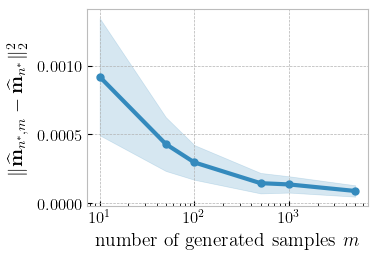

In [10]:
# Plot the average mean squared error and its standard deviation against m
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('bmh')
fontsize = 12
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': True,
      'errorbar.capsize': 4}
plt.rcParams.update(params)
plt.rc('font', family='Times')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [4, 5]
lw = 3
ms = 5

plt.figure(1)

# Plot for the mean
plt.subplot(2, 1, 1)
plot_mu, = plt.semilogx(range_m, mse_mean.mean(axis=1), 'o-', lw=lw, ms=ms)
color = plot_mu.get_color()
plt.fill_between(range_m, mse_mean.mean(axis=1) - mse_mean.std(axis=1), 
                 mse_mean.mean(axis=1) + mse_mean.std(axis=1), alpha=0.2, color=color)
plt.xlabel('number of generated samples $m$')
plt.ylabel('$\| \widehat{\mathbf{m}}_{n^*,m} - \widehat{\mathbf{m}}_{n^*} \|_2^2$')
plt.tight_layout()

# Save and show figure
fig = plt.gcf()
figpath = os.path.join('figures', 'ellipstable_convergence_meswe_to_mswe.pdf')
fig.savefig(figpath)
plt.show()
plt.close()
